In [2]:
import nibabel as nib
from nibabel import processing as prc
import numpy as np
import scipy.stats as stats
import os

In [3]:
subjectlist = open('/media/corey/4TB-WDBlue/data-thesis/subject_list_full.txt')
sublist = subjectlist.readlines()

In [ ]:
for n, sub in enumerate(sublist):
    sub = sub.strip()
    aparc = nib.load('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/MNINonLinear/aparc+aseg.nii.gz' %sub)
    aparc_data = aparc.get_fdata()
    affine = aparc.affine
    maskname = str('/media/corey/4TB-WDBlue/data-thesis/fMRI/Rapidtide/%s_01_MR/PA/masks/adjusted_s-rfMRI_mask.nii' %sub)
    epi_mask = nib.load(maskname)

#Generate mask and resample to MNI152 2mm space (to match epi time series)
    gm_mask = np.zeros_like(aparc_data)
    for x in range(0,gm_mask.shape[0]-1): #Loop method
        for y in range(0,gm_mask.shape[1]-1):
            for z in range(0,gm_mask.shape[2]-1):
                if aparc_data[x,y,z] >= 1000:
                    gm_mask[x,y,z] = 1
    
    gm_mask_nifti = nib.Nifti1Image(gm_mask,affine)

    resampled_gm_mask = prc.resample_from_to(gm_mask_nifti,epi_mask,order=0)
   
    nib.save(resampled_gm_mask,'/media/corey/4TB-WDBlue/data-thesis/fMRI/Rapidtide/%s_01_MR/PA/masks/resampled_gm_mask.nii.gz' %sub)

#EPI can now be multiplied with resampled gm_mask and averaged using FSL (extracting average global gm signal in each volume)

In [ ]:
subjectlist = open('/media/corey/4TB-WDBlue/data-thesis/subject_list_full.txt')
sublist = subjectlist.readlines()

for n, sub in enumerate(sublist):
    sub = sub.strip()
    wmparc = nib.load('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/MNINonLinear/wmparc.nii.gz' %sub)
    wmparc_data = wmparc.get_fdata()
    affine = wmparc.affine
    if os.path.exists('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/rfMRI_REST1_PA/'):
        epi_mask = nib.load('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/MNINonLinear/Results/rfMRI_REST1_PA/rfMRI_REST1_PA_finalmask.nii.gz' %sub)
    if os.path.exists('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/rfMRI_REST2_PA/'):
        epi_mask = nib.load('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/MNINonLinear/Results/rfMRI_REST2_PA/rfMRI_REST2_PA_finalmask.nii.gz' %sub)
    
#Generate mask and resample to MNI152 2mm space (to match epi time series)
    wm_mask = np.zeros_like(wmparc_data)

    for x in range(0,wm_mask.shape[0]-1):
        for y in range(0,wm_mask.shape[1]-1):
            for z in range(0,wm_mask.shape[2]-1):
                if wmparc_data[x,y,z] >= 3000:
                    wm_mask[x,y,z] = 1
    wm_mask_nifti = nib.Nifti1Image(wm_mask,affine)

    resampled_wm_mask = prc.resample_from_to(wm_mask_nifti,epi_mask,order=0)
    nib.save(resampled_wm_mask,'/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/resampled_wm_mask.nii.gz' %sub)

In [11]:
#New center at 45, 44, 37
opt_r = []
opt_p = []
opt_swsc = []
cerebellar_mask = nib.load('/usr/local/fsl/data/atlases/Cerebellum/Cerebellum-MNIflirt-maxprob-thr0-2mm.nii.gz')
cerb_data = cerebellar_mask.get_fdata()
for n, sub in enumerate(sublist):
    sub = sub.strip()
    gm_signal = nib.load('/media/corey/4TB-WDBlue/data-thesis/fMRI/Rapidtide/%s_01_MR/PA/fMRI/gm_signal.nii.gz' %sub)
    gmdata = gm_signal.get_fdata()
    avgd_gm = []
    avg_vent4 = []
    filename = str('/media/corey/4TB-WDBlue/data-thesis/fMRI/Rapidtide/%s_01_MR/PA/fMRI/smoothedRT_ts_PA.nii.gz' %sub)
    epi_ts = nib.load(filename)
    epi_data = epi_ts.get_fdata()
    wm_mask = nib.load('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/resampled_wm_mask.nii.gz' %sub)
    gm_mask = nib.load('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/resampled_gm_mask.nii.gz' %sub)
    wm_data = wm_mask.get_fdata()
    gm_mask_data = gm_mask.get_fdata()
    vent4_sphere = epi_data[41:49,41:49,31:39,:] #4th ventricle
    avg_v4_sphere = np.mean(vent4_sphere,axis=3)
    vent4_min = np.unravel_index(np.argmin(avg_v4_sphere,axis=None),shape=avg_v4_sphere.shape)
    new_center = vent4_min
    offsets = [41 + new_center[0], 41 + new_center[1], 31 + new_center[2]]
    new_sphere = epi_data[offsets[0]-1:offsets[0]+1,offsets[1]-1:offsets[1]+1,offsets[2]-1:offsets[2]+1,:]
    
    for x in range(0,new_sphere.shape[0]):
        for y in range(0,new_sphere.shape[1]):
            for z in range(0,new_sphere.shape[2]):
                if wm_data[x+offsets[0],y+offsets[1],z+offsets[2]] > 0 or cerb_data[x+offsets[0],y+offsets[1],z+offsets[2]] > 0 or gm_mask_data[x+offsets[0],y+offsets[1],z+offsets[2]] > 0:
                    new_sphere[x,y,z,:] = 0
    #new_sphere[new_sphere > 8000] = 0
    for t in range(0,gmdata.shape[3]):
        avg_gm = np.true_divide(gmdata[:,:,:,t].sum(1),(gmdata[:,:,:,t]!=0).sum(1))
        mean_gm_signal = np.nanmean(avg_gm)
        avgd_gm.append(mean_gm_signal)
        avg_csf = np.true_divide(new_sphere[:,:,:,t].sum(1),(new_sphere[:,:,:,t]!=0).sum(1))
        mean_signal_v4 = np.nanmean(avg_csf)
        avg_vent4.append(mean_signal_v4)

    v4 = np.array(avg_vent4)
    gm = np.array(avgd_gm)
    sp_corr4, p4 = stats.pearsonr(v4,gm)
    opt_r.append(sp_corr4)
    opt_p.append(p4)
    if p4 <= 0.05:
        opt_swsc.append(sub)
        print(n,sub,'significant correlation of csf to gm', offsets, sp_corr4)
    else:
        print(n,sub, offsets, sp_corr4)

/tmp/ipykernel_12078/819933422.py:34: RuntimeWarning: invalid value encountered in divide
  avg_gm = np.true_divide(gmdata[:,:,:,t].sum(1),(gmdata[:,:,:,t]!=0).sum(1))


0 1001 significant correlation of csf to gm [44, 42, 38] 0.4967106352015942
1 1002 significant correlation of csf to gm [45, 43, 38] 0.22613464843611822
2 1003 significant correlation of csf to gm [45, 43, 38] 0.2696073465127875
3 1004 significant correlation of csf to gm [45, 43, 38] 0.20454876579770145
4 1005 significant correlation of csf to gm [44, 43, 37] 0.46167133349133926
5 1006 [44, 43, 38] -0.03338960440468296
6 1009 [45, 42, 38] 0.07395142081358515
7 1010 significant correlation of csf to gm [45, 43, 38] 0.3362874295836411
8 1012 significant correlation of csf to gm [44, 43, 38] 0.6892118573060662
9 1013 significant correlation of csf to gm [45, 41, 38] 0.45242243786617564
10 1015 significant correlation of csf to gm [45, 41, 38] 0.36079969763832503
11 1017 significant correlation of csf to gm [44, 42, 38] 0.3542285040472455
12 1018 significant correlation of csf to gm [45, 42, 38] 0.10869606196244433
13 1020 significant correlation of csf to gm [45, 42, 38] 0.20272433744064

In [12]:
print(len(opt_swsc))

140


In [7]:
v1_gm_correlations = []
v2_gm_correlations = []
v4_gm_correlations = []
p1s = []
p2s = []
p4s = []
sub_with_sig_corr4 = []
swsc1 = []
swsc2 = []
cerebellar_mask = nib.load('/usr/local/fsl/data/atlases/Cerebellum/Cerebellum-MNIflirt-maxprob-thr0-2mm.nii.gz')
for n, sub in enumerate(sublist):
    sub = sub.strip()
    gm_signal = nib.load('/media/corey/4TB-WDBlue/data-thesis/fMRI/Rapidtide/%s_01_MR/PA/fMRI/gm_signal.nii.gz' %sub)
    data = gm_signal.get_fdata()
    wm_mask = nib.load('/media/corey/My_Passport/DATA/fMRI/ext_data/EP_FunctionalPreprocessing/%s_01_MR/resampled_wm_mask.nii.gz' %sub)
    avgd_gm = []
    for t in range(0,data.shape[3]):
        num_nz = np.count_nonzero(data[:,:,:,t])
        sum_gmSig = np.sum(data[:,:,:,t])
        avg = sum_gmSig / num_nz
        avgd_gm.append(avg)
        filename = str('/media/corey/4TB-WDBlue/data-thesis/fMRI/Rapidtide/%s_01_MR/PA/fMRI/smoothedRT_FWHM6mm.nii.gz' %sub)
    epi_ts = nib.load(filename)
    epi_data = epi_ts.get_fdata()
    vent4_sphere = epi_data[44:45,44:45,34:36,:] #4th ventricle
    vent1_sphere = epi_data[33:39,41:47,42:48,:] #Primary ventricle (along CC, posterior)
    vent2_sphere = epi_data[40:46,65:71,39:45,:] #Primary ventricle (along CC, anterior)
    avg_vent4 = []
    avg_vent1 = []
    avg_vent2 = []
    for t in range(0,vent4_sphere.shape[3]):    
        v4_avg = np.mean(vent4_sphere[:,:,:,t])
        v1_avg = np.mean(vent1_sphere[:,:,:,t])
        v2_avg = np.mean(vent2_sphere[:,:,:,t])
        avg_vent4.append(v4_avg)
        avg_vent1.append(v1_avg)
        avg_vent2.append(v2_avg)

    v4 = np.array(avg_vent4)
    v1 = np.array(avg_vent1)
    v2 = np.array(avg_vent2)
    gm = np.array(avgd_gm)
    sp_corr4, p4 = stats.pearsonr(v4,gm)
    sp_corr1, p1 = stats.pearsonr(v1,gm)
    sp_corr2, p2 = stats.pearsonr(v2,gm)
    v1_gm_correlations.append(sp_corr1)
    v2_gm_correlations.append(sp_corr2)
    v4_gm_correlations.append(sp_corr4)
    p1s.append(p1)
    p2s.append(p2)
    p4s.append(p4)
    if p4 <= 0.05:
        sub_with_sig_corr4.append(sub)
        print(sub, 'correlated')
    if p1 <= 0.05:
        swsc1.append(sub)
    if p2 <= 0.05:
        swsc2.append(sub)
    print(sub)

1001 correlated
1001
1002
1003 correlated
1003
1004
1005 correlated
1005
1006
1009 correlated
1009
1010 correlated
1010
1012 correlated
1012
1013 correlated
1013
1015
1017 correlated
1017
1018
1020 correlated
1020
1021 correlated
1021
1022 correlated
1022
1024 correlated
1024
1025 correlated
1025
1026 correlated
1026
1027
1028 correlated
1028
1029 correlated
1029
1031
1032 correlated
1032
1033 correlated
1033
1034 correlated
1034
1035
1036
1037 correlated
1037
1038
1039 correlated
1039
1040 correlated
1040
1041 correlated
1041
1043 correlated
1043
1044 correlated
1044
1045
1047
1048 correlated
1048
1051 correlated
1051
1052 correlated
1052
1053 correlated
1053
1054 correlated
1054
1056
1057 correlated
1057
1060 correlated
1060
1061
1063
1065 correlated
1065
1067 correlated
1067
1068 correlated
1068
1069 correlated
1069
1070 correlated
1070
1072 correlated
1072
1074 correlated
1074
1075
1076 correlated
1076
1077
1078 correlated
1078
1079
1080 correlated
1080
1081
1082
1083
1084 correlat

In [8]:
print(len(sub_with_sig_corr4))
print(sub_with_sig_corr4)
print(len(swsc1))
print(swsc1)
print(len(swsc2))
print(swsc2)

111
['1001', '1003', '1005', '1009', '1010', '1012', '1013', '1017', '1020', '1021', '1022', '1024', '1025', '1026', '1028', '1029', '1032', '1033', '1034', '1037', '1039', '1040', '1041', '1043', '1044', '1048', '1051', '1052', '1053', '1054', '1057', '1060', '1065', '1067', '1068', '1069', '1070', '1072', '1074', '1076', '1078', '1080', '1084', '1086', '1087', '1088', '1089', '1093', '1094', '1095', '1099', '1104', '2004', '2005', '2006', '2007', '2008', '2010', '2012', '2014', '2015', '2016', '2029', '2031', '2040', '2041', '2044', '2046', '2048', '2062', '3001', '3011', '3021', '3026', '3027', '3029', '3030', '3031', '3032', '3034', '3039', '4002', '4003', '4004', '4005', '4006', '4010', '4011', '4012', '4014', '4027', '4028', '4030', '4035', '4036', '4037', '4047', '4049', '4050', '4052', '4053', '4058', '4063', '4064', '4065', '4069', '4071', '4072', '4074', '4075', '4091']
96
['1001', '1002', '1003', '1004', '1009', '1012', '1013', '1015', '1024', '1025', '1026', '1027', '1028',

In [9]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'count')

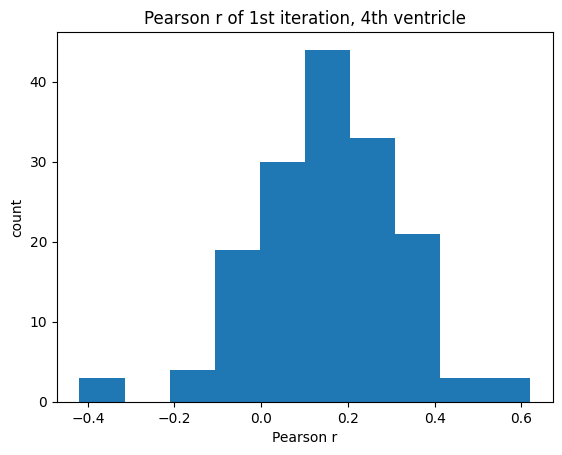

In [10]:
plt.hist(v4_gm_correlations)
plt.title('Pearson r of 1st iteration, 4th ventricle')
plt.xlabel('Pearson r')
plt.ylabel("count")